# 프로젝트: CAM을 만들고 평가해 보자
---
|평가문항|상세기준|
|:---|:---|
|1. CAM을 얻기 위한 기본모델의 구성과 학습이 정상 진행되었는가?|ResNet50 + GAP + DenseLayer 결합된 CAM 모델의 학습과정이 안정적으로 수렴하였다.|
|2. 분류근거를 설명 가능한 Class activation map을 얻을 수 있는가?|CAM 방식과 Grad-CAM 방식의 class activation map이 정상적으로 얻어지며, 시각화하였을 때 해당 object의 주요 특징 위치를 잘 반영한다.
|3. 인식결과의 시각화 및 성능 분석을 적절히 수행하였는가?|CAM과 Grad-CAM 각각에 대해 원본이미지합성, 바운딩박스, IoU 계산 과정을 통해 CAM과 Grad-CAM의 object localization 성능이 비교분석되었다.|

### 데이터 준비
---
Tensorflow Datasets stanford_dogs

In [48]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import copy
import cv2

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


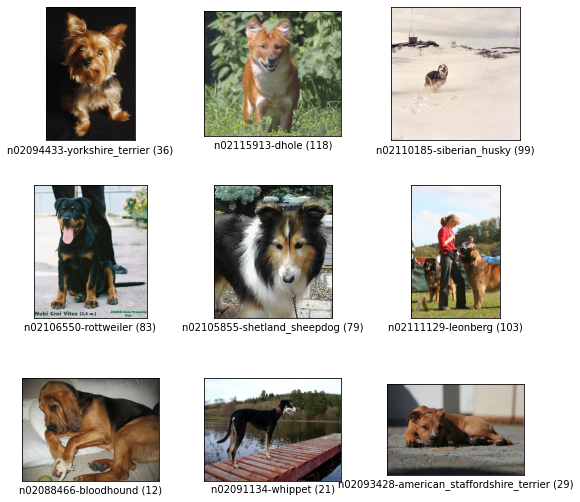

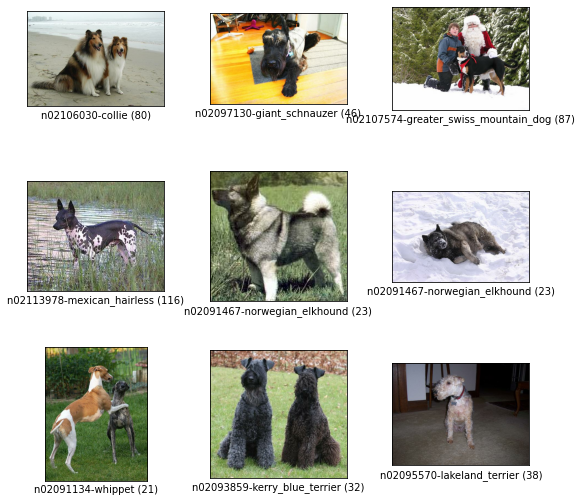

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

In [4]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
tfds.show_examples(ds_train, ds_info)
tfds.show_examples(ds_test, ds_info)
ds_info.features

116


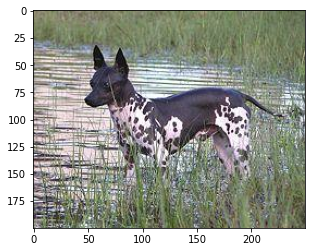

In [33]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

---
## CAM 모델 생성
---


In [6]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation = 'softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

cam_model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_____________________________

### 모델 학습

In [15]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print('image.shape', image.shape)
    print('label.shape', label.shape)

cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=30,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
    callbacks = [
        ModelCheckpoint('./project_cam_model.h5', save_best_only=True)
    ]
)

image.shape (16, 224, 224, 3)
label.shape (16,)
Epoch 1/30
750/750 [==============================] - 153s 199ms/step - loss: 2.2582 - accuracy: 0.4326 - val_loss: 3.5155 - val_accuracy: 0.1905


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/30
750/750 [==============================] - 150s 200ms/step - loss: 0.6566 - accuracy: 0.8247 - val_loss: 1.2887 - val_accuracy: 0.6300
Epoch 3/30
750/750 [==============================] - 166s 221ms/step - loss: 0.1855 - accuracy: 0.9688 - val_loss: 1.0135 - val_accuracy: 0.7087
Epoch 4/30
750/750 [==============================] - 150s 200ms/step - loss: 0.0614 - accuracy: 0.9969 - val_loss: 1.0092 - val_accuracy: 0.7186
Epoch 5/30
750/750 [==============================] - 150s 200ms/step - loss: 0.0297 - accuracy: 0.9990 - val_loss: 0.9817 - val_accuracy: 0.7284
Epoch 6/30
750/750 [==============================] - 150s 200ms/step - loss: 0.0562 - accuracy: 0.9953 - val_loss: 1.0602 - val_accuracy: 0.7118
Epoch 7/30
750/750 [==============================] - 150s 200ms/step - loss: 0.0183 - accuracy: 0.9987 - val_loss: 1.0062 - val_accuracy: 0.7281
Epoch 8/30
750/750 [==============================] - 150s 200ms/step - loss: 0.0120 - accuracy: 0.9992 - val_loss: 1.0335 -

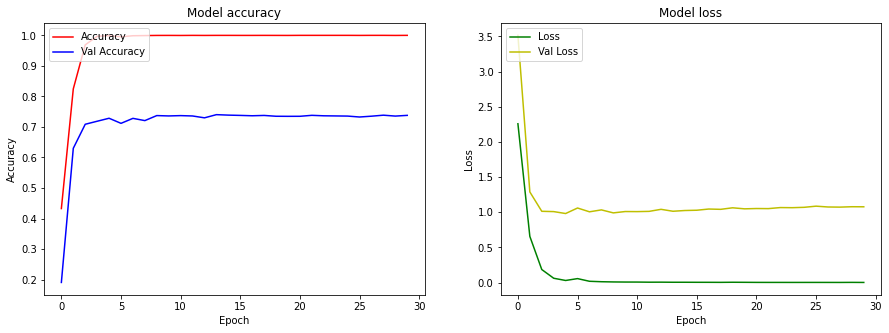

In [28]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(history_cam_model.history['accuracy'], 'r')
ax[0].plot(history_cam_model.history['val_accuracy'], 'b')
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Accuracy', 'Val Accuracy'], loc='upper left')

ax[1].plot(history_cam_model.history['loss'], 'g')
ax[1].plot(history_cam_model.history['val_loss'], 'y')
ax[1].set_title('Model loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Loss', 'Val Loss'], loc='upper left')
plt.show()

In [29]:
project_cam_model = load_model("./project_cam_model.h5")
project_cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

---
### CAM 구현하기

In [42]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

In [51]:
def visualize_cam_on_image(image, cam_image, alpha=0.5):
    src1 = item['image'].astype(np.uint8)
    src2 = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)    
    merged_image = cv2.addWeighted(src1, alpha, src2, (1.0 - alpha), 0.0)
    return merged_image

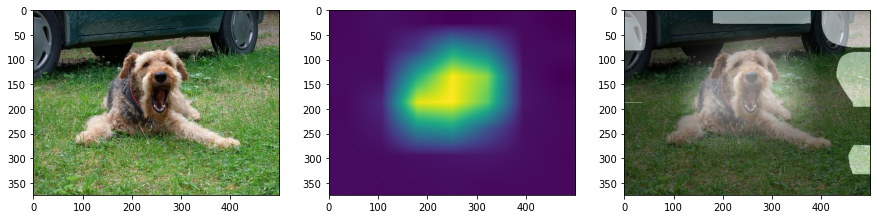

In [53]:
item = get_one(ds_test)

plt.subplots(1,3, figsize=(15,5))

image = item['image']
plt.subplot(1,3,1)
plt.imshow(image)

cam_image = generate_cam(project_cam_model, item)
plt.subplot(1,3,2)
plt.imshow(cam_image)

merged_image = visualize_cam_on_image(image, cam_image)
plt.subplot(1,3,3)
plt.imshow(merged_image)

plt.show()

### Grad-CAM 구현하기

In [55]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 이때 원하는 레이어의 이름으로 찾은 후 output으로 추가
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

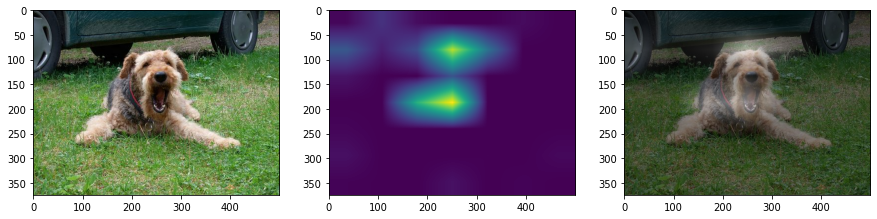

In [57]:
item = get_one(ds_test)

plt.subplots(1,3, figsize=(15,5))

image = item['image']
plt.subplot(1,3,1)
plt.imshow(image)

grad_cam_image = generate_grad_cam(project_cam_model, 'conv5_block3_out', item)
plt.subplot(1,3,2)
plt.imshow(grad_cam_image)

merged_image = visualize_cam_on_image(image, grad_cam_image)
plt.subplot(1,3,3)
plt.imshow(merged_image)

plt.show()

### 바운딩 박스 구하기

In [58]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

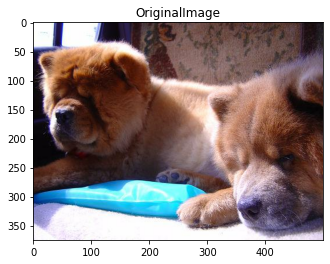

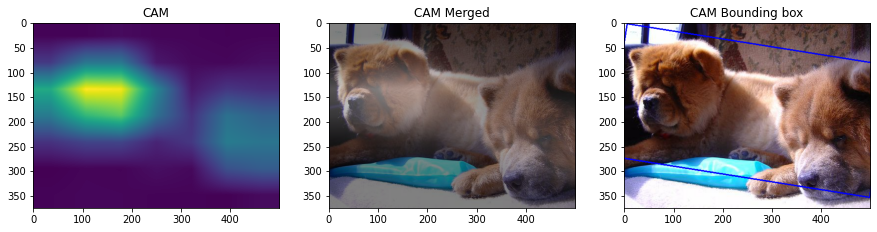

In [66]:
item = get_one(ds_test)

image = item['image']
plt.imshow(image)
plt.title('OriginalImage')
plt.show()

plt.subplots(1,3, figsize=(15,10))

cam_image = generate_cam(project_cam_model, item)
plt.subplot(1,3,1)
plt.title('CAM')
plt.imshow(cam_image)

merged_image = visualize_cam_on_image(image, cam_image)
plt.subplot(1,3,2)
plt.title('CAM Merged')
plt.imshow(merged_image)

rect = get_bbox(cam_image)
bbox_image = copy.deepcopy(item['image'])
bbox_image = cv2.drawContours(bbox_image, [rect], 0, (0,0,255), 2)
plt.subplot(1,3,3)
plt.title('CAM Bounding box')
plt.imshow(bbox_image)

plt.show()



### IoU 구하기

In [67]:
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

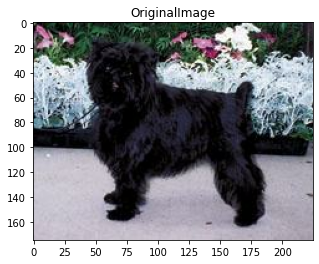

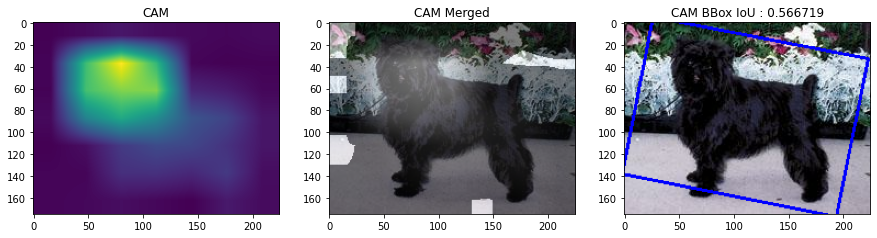

In [75]:
def show_cam(item, cam_image, title='CAM'):
    image = item['image']
    
    plt.subplots(1,3, figsize=(15,10))
    plt.subplot(1,3,1)
    plt.title(title)
    plt.imshow(cam_image)
    
    merged_image = visualize_cam_on_image(image, cam_image)
    plt.subplot(1,3,2)
    plt.title(title + ' Merged')
    plt.imshow(merged_image)
    
    rect = get_bbox(cam_image)
    bbox_image = copy.deepcopy(item['image'])
    bbox_image = cv2.drawContours(bbox_image, [rect], 0, (0,0,255), 2)

    cam_bbox = rect_to_minmax(rect, item['image'])    
    label_bbox = item['objects']['bbox'][0]
    iou = get_iou(cam_bbox, label_bbox)
    iou_title = title + ' BBox IoU : %f' % iou

    plt.subplot(1,3,3)
    plt.title(iou_title)
    plt.imshow(bbox_image)

    plt.show()

item = get_one(ds_test)

image = item['image']
plt.imshow(image)
plt.title('OriginalImage')
plt.show()

cam_image = generate_cam(project_cam_model, item)
show_cam(item, cam_image)


### CAM vs Grad-CAM

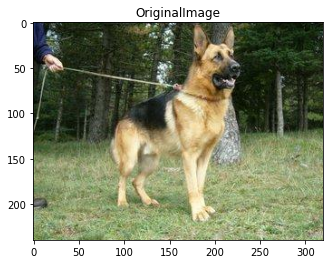

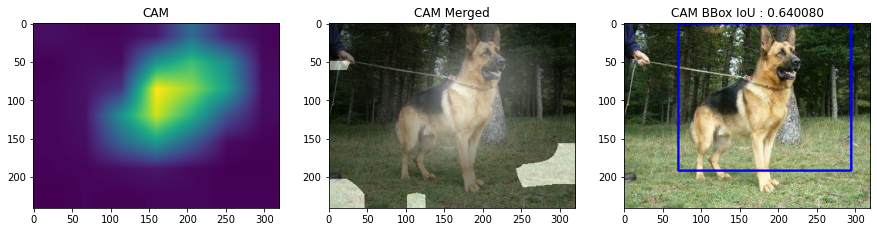

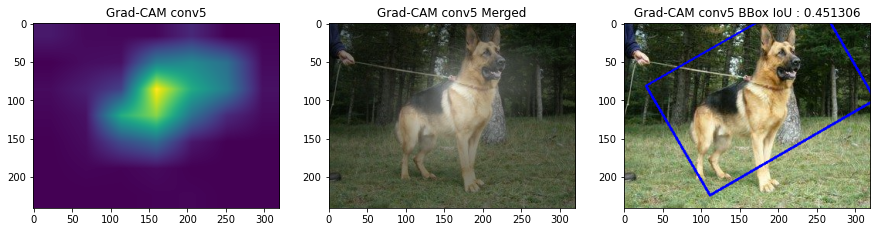

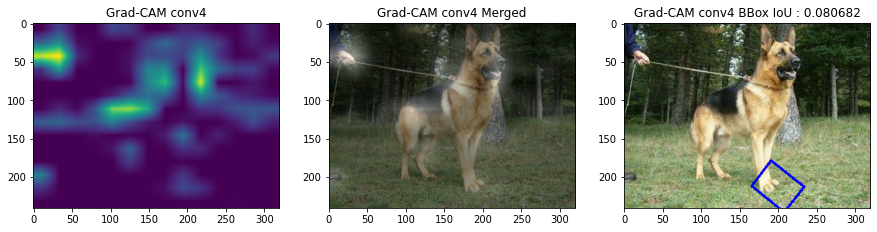

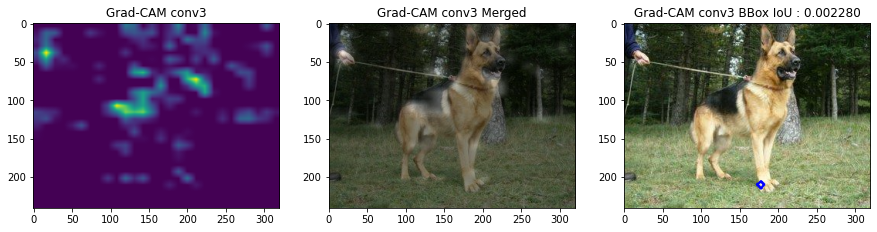

In [79]:
item = get_one(ds_test)

image = item['image']
plt.imshow(image)
plt.title('OriginalImage')
plt.show()

cam_image = generate_cam(project_cam_model, item)
show_cam(item, cam_image)

grad_conv5_image = generate_grad_cam(project_cam_model, 'conv5_block3_out', item)
show_cam(item, grad_conv5_image, 'Grad-CAM conv5')

grad_conv5_image = generate_grad_cam(project_cam_model, 'conv4_block3_out', item)
show_cam(item, grad_conv5_image, 'Grad-CAM conv4')

grad_conv5_image = generate_grad_cam(project_cam_model, 'conv3_block3_out', item)
show_cam(item, grad_conv5_image, 'Grad-CAM conv3')